<a href="https://colab.research.google.com/github/Ved0715/Fake-news-Detection/blob/main/Fake_News_Classification_Using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Fake News Detection using LSTM</h1>

---



This notebook will walk you through the process of detecting fake news using a Long Short-Term Memory (LSTM) neural network. We will start by loading the data and exploring its features. Then, we will train the LSTM model and evaluate its performance. Finally, we will finish this notebook with conclusion.

##Importing Libraries

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

##Configuration

In [2]:
class CFG:
    sequence_length = 1024
    vocab_size = 10000

##Loading the Data

In [3]:
negative_df = pd.read_csv("true.csv")
negative_df["fake"] = 0.0
positive_df = pd.read_csv("fake.csv")
positive_df["fake"] = 1.0
train_df = pd.concat([negative_df, positive_df])
train_df.head()

,title,text,subject,date,fake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0.0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0.0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0.0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0.0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0.0


##Exploring the Data

Plot a bar chart to visualize the value counts of the "fake" column in the train_df dataframe. It helps us see the distribution of fake and non-fake values in the dataset.

<Axes: >

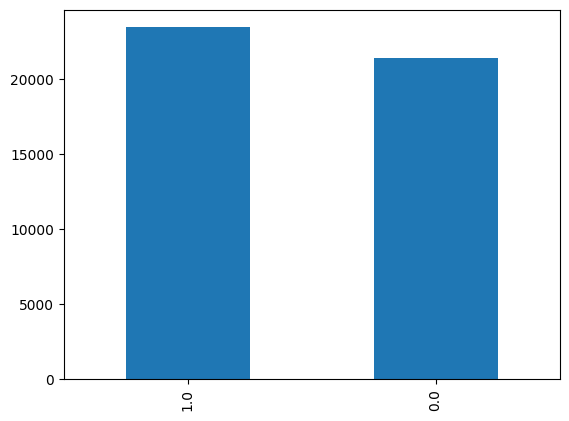

In [4]:
train_df.fake.value_counts().plot(kind="bar")

Add two new columns to your dataframe. The first column, "title_length", calculates the number of words in the "title" column using the lambda function. The second column, "text_length", does the same thing but for the "text" column. This will be helpful for analyzing the length of titles and texts in this dataset.

In [5]:
train_df["title_length"] = train_df["title"].apply(lambda title: len(title.split(" ")))
train_df["text_length"] = train_df["text"].apply(lambda text: len(text.split(" ")))

Generate descriptive statistics for the "title_length" and "text_length" columns. It provides useful information such as count, mean, standard deviation, minimum value, and quartiles. This summary gives us a quick overview of the distribution and basic statistics of the lengths of the titles and texts in the dataset.

In [6]:
train_df[["title_length", "text_length"]].describe()

,title_length,text_length
count,44898.000000,44898.000000
mean,12.657245,415.760412
std,4.170713,361.648003
min,1.000000,1.000000
25%,10.000000,208.000000
50%,12.000000,371.000000
75%,15.000000,525.000000
max,45.000000,8436.000000


Visualize the distribution of values of title length and text length.

<Axes: ylabel='Frequency'>

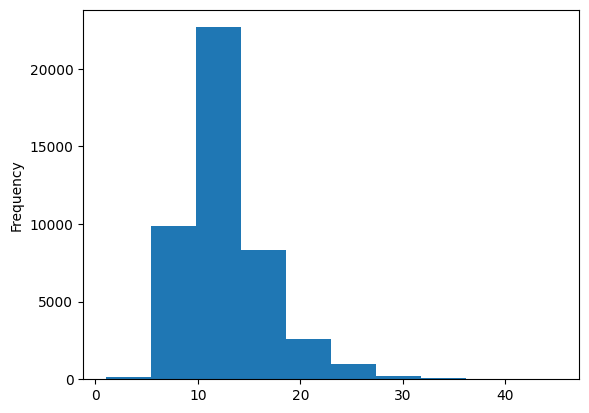

In [7]:
train_df["title_length"].plot(kind="hist")

<Axes: ylabel='Frequency'>

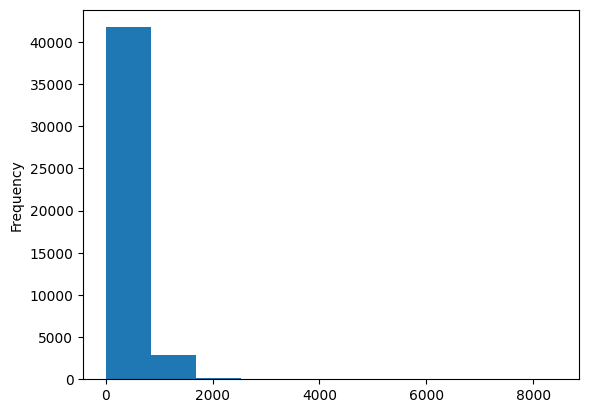

In [8]:
train_df["text_length"].plot(kind="hist")

##Create tensorflow dataset

This code splits the train_df dataframe into training and validation sets. It uses a test size of 0.2, maintains the distribution of the fake column, and sets a random state of 42.

In [9]:
train_data, valid_data = train_test_split(train_df, test_size=0.2, stratify=train_df["fake"], random_state=42)
train_data.shape, valid_data.shape

((35918, 7), (8980, 7))

In [10]:
def create_dataset(dataframe, shuffle=True):
    # Create a TensorFlow dataset from the text and fake columns of the dataframe
    dataset = tf.data.Dataset.from_tensor_slices((dataframe["text"], dataframe["fake"]))
    if shuffle:
         # Shuffle the dataset if the shuffle parameter is True
        dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
    # Batch the dataset into smaller batches of size 256
    dataset = dataset.batch(256).cache().prefetch(tf.data.AUTOTUNE)
    # Prefetch the next batch of data to further optimize training
    return dataset

Create tensorflow training dataset and validation dataset.

In [11]:
train_ds = create_dataset(train_data)
valid_ds = create_dataset(valid_data, shuffle=False)

##Training the LSTM Model

In [12]:
# Create a TextVectorization layer with specified parameters
vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=CFG.vocab_size,
    output_sequence_length=CFG.sequence_length,
    pad_to_max_tokens=True
)
# Adapt the TextVectorization layer to the training data
vectorizer.adapt(train_df["text"], batch_size=1024)


In this code, we create a Sequential model using `tf.keras.Sequential`. The model consists of several layers:

Input layer for text data

*   TextVectorization layer (vectorizer) that processes the text data
*   Embedding layer that converts the processed text into dense vectors

*  Two Bidirectional LSTM layers that capture the sequential information in both directions
*   Two Bidirectional LSTM layers that capture the sequential information in both directions

*   Two Bidirectional LSTM layers that capture the sequential information in both directions
*   Dense layers with ReLU activation

*   Output layer with sigmoid activation for binary classification














We then compile the model with a binary crossentropy loss, Adam optimizer with a learning rate of 1e-3, and metrics such as accuracy and AUC.

Finally, we print a summary of the model's architecture and plot the model's architecture using `tf.keras.utils.plot_model()`.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 1024)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 1024, 64)          640000    
                                                                 
 bidirectional (Bidirection  (None, 1024, 128)         66048     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                        

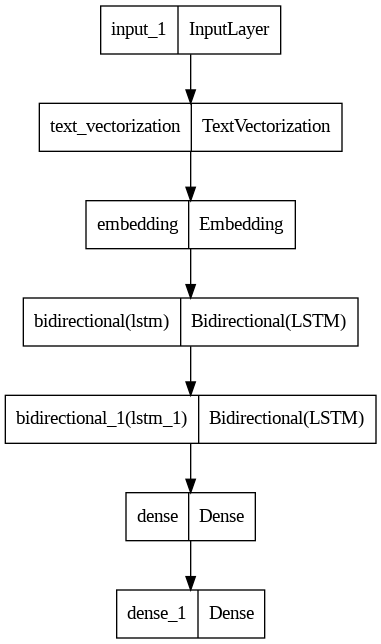

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    vectorizer,
    tf.keras.layers.Embedding(
        input_dim=CFG.vocab_size,
        output_dim=64,
        input_length=CFG.sequence_length,
        mask_zero=True
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(name="auc")
    ]
)
model.summary()
tf.keras.utils.plot_model(model)

The code fits the model to the training data for 10 epochs using the validation data for evaluation. It also includes a ModelCheckpoint callback that saves the best model weights based on validation accuracy.

In [ ]:
file_path = "model.tf"
history = model.fit(
    train_ds,
    epochs=15,
    validation_data=valid_ds,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(
            file_path,
            save_best_only=True,
            monitor='val_accuracy',
            mode='max'
        )
    ]
)

Epoch 1/15
141/141 [==============================] - 1276s 9s/step - loss: 0.1341 - accuracy: 0.9635 - auc: 0.9951 - val_loss: 0.0210 - val_accuracy: 0.9979 - val_auc: 0.9987
Epoch 2/15
141/141 [==============================] - 1232s 9s/step - loss: 0.0161 - accuracy: 0.9989 - auc: 0.9995 - val_loss: 0.0146 - val_accuracy: 0.9987 - val_auc: 0.9994
Epoch 3/15
141/141 [==============================] - 1239s 9s/step - loss: 0.0120 - accuracy: 0.9994 - auc: 0.9998 - val_loss: 0.0131 - val_accuracy: 0.9989 - val_auc: 0.9996
Epoch 4/15
141/141 [==============================] - 1218s 9s/step - loss: 0.0097 - accuracy: 0.9996 - auc: 0.9999 - val_loss: 0.0115 - val_accuracy: 0.9990 - val_auc: 0.9995
Epoch 5/15
141/141 [==============================] - 1154s 8s/step - loss: 0.0072 - accuracy: 0.9998 - auc: 1.0000 - val_loss: 0.0125 - val_accuracy: 0.9987 - val_auc: 0.9994
Epoch 6/15
141/141 [==============================] - 1142s 8s/step - loss: 0.0062 - accuracy: 0.9998 - auc: 1.0000 - va

In [1]:
model.save_weights('model.hdf5')
model.save_weights('FakeNewsLSTM.h5')

NameError: name 'model' is not defined

##Plot learning curve

In [ ]:
def plot_learning_curve(history):
  plt.figure(figsize=(12, 8))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='upper right')

  plt.figure(figsize=(12, 8))
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='upper right')

  plt.figure(figsize=(12, 8))
  plt.plot(history.history['auc'])
  plt.plot(history.history['val_auc'])
  plt.title('AUC')
  plt.ylabel('AUC')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='upper right')
  plt.show()
plot_learning_curve(history)

##Conclusion

In this notebook, we have shown how to use a LSTM neural network to detect fake news. We started by loading the data. Then we exploring its features. Finally, we trained the LSTM model and evaluated its performance.

The LSTM model was able to achieve an accuracy of 99.8% ~ 99.9% on the validation set. This means that the model was able to correctly classify 998 ~ 999 out of 1000 articles as real or fake news. This is a very promising result, and suggests that LSTMs can be used to effectively detect fake news.

However, it is important to note that the LSTM model is not perfect. It is possible for the model to make mistakes, and there will always be some articles that the model will not be able to classify correctly. Therefore, it is important to use the LSTM model in conjunction with other methods of detecting fake news, such as human common sense and fact-checking.

Overall, the LSTM model is a powerful tool that can be used to detect fake news. It is easy to use and can achieve high accuracy. However, it is important to remember that the model is not perfect and that it should be used in conjunction with other methods of detecting fake news.